In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import Lasso, LassoCV, LogisticRegression, LogisticRegressionCV, LinearRegression,\
    ElasticNet, ElasticNetCV, MultiTaskElasticNet, MultiTaskElasticNetCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline

from pathlib import Path
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from sklearn.cluster import KMeans
#from mliv.neuralnet.deepiv_fit import deep_iv_fit
from mliv.neuralnet.rbflayer import gaussian, inverse_multiquadric
from mliv.neuralnet import AGMM

device = torch.cuda.current_device() if torch.cuda.is_available() else None

In [2]:
#from mliv.neuralnet.deepiv_fit import deep_iv_fit
import mliv.dgps_mediated as dgps
from mliv.rkhs import ApproxRKHSIVCV, RKHSIVCV
from mliv.tsls import tsls, regtsls

In [3]:
from dml_longterm import DML_longterm
from dml_npiv import DML_npiv
from dml_mediated import DML_mediated

In [4]:
df = pd.read_csv('../data/data_star.csv', header=0)

# Bind covariates
Xnan = df[["z_score_prior"]].values
X = df[["z_score_prior"]].values
G = df[["G"]].values
D = df[["D"]].values
S = df[["z_score3"]].values
V = df[["z_score_prior"]].values
Y = df[["z_score8"]].values


#drop NaNs
X = X[~np.isnan(Xnan)].reshape(-1,1)
G = G[~np.isnan(Xnan)].reshape(-1,1)
D = D[~np.isnan(Xnan)].reshape(-1,1)
S = S[~np.isnan(Xnan)].reshape(-1,1)
Y = Y[~np.isnan(Xnan)].reshape(-1,1)
V = V[~np.isnan(Xnan)].reshape(-1,1)

ones = np.ones((X.shape[0], 1))

In [5]:
percentiles = np.arange(5, 100, 5)
#Input the vector little v where wwe want to center local estimate theta
v_values = np.percentile(V, percentiles)


In [6]:
p = 0.1  # dropout prob of dropout layers throughout notebook
n_hidden = 200  # width of hidden layers throughout notebook


def _get_learner(n_t):
    return nn.Sequential(nn.Dropout(p=p), nn.Linear(n_t, n_hidden), nn.LeakyReLU(),
                         nn.Dropout(p=p), nn.Linear(n_hidden, 1))


def _get_adversary(n_z):
    return nn.Sequential(nn.Dropout(p=p), nn.Linear(n_z, n_hidden), nn.LeakyReLU(),
                         nn.Dropout(p=p), nn.Linear(n_hidden, 1))


m1 = AGMM(_get_learner(1),_get_adversary(1))
m2 = AGMM(_get_learner(2),_get_adversary(2))

In [7]:
#m1 = tsls()
#m2 = tsls()

In [8]:
ind = np.where(G == 0)[0]
Y1 = Y[ind]
D1 = D[ind]
X11 = X[ind]
ones1 = ones[ind]

dml_npiv = DML_npiv(Y1, D1, ones1, ones1, V=X11, v_values = v_values,
                        estimator='MR',
                        loc_kernel='gau',
                        bw_loc='silverman',
                        model1 = m1,
                        nn_1 = True,
                        modelq1 = tsls(),
                        nn_q1 = False,
                n_folds=5, n_rep=1, CHIM = False, prop_score=LogisticRegression(max_iter=2000), opts = {'lin_degree': 11})

theta_oracle, vart_oracle, ci_oracle = dml_npiv.dml()

lower_ci_oracle = ci_oracle[:, 0]
upper_ci_oracle = ci_oracle[:, 1]
yerr_oracle = [theta_oracle - lower_ci_oracle, upper_ci_oracle - theta_oracle]


Rep: 1


100%|██████████| 5/5 [00:50<00:00, 10.20s/it]


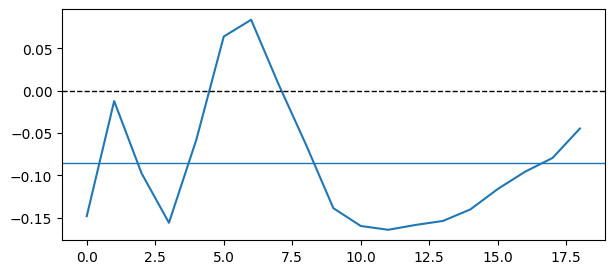

In [9]:

plt.figure(figsize=(7, 3))
plt.plot(theta_oracle)
plt.axhline(np.mean(theta_oracle, axis=0), linewidth=1)  # Adjust line properties as needed
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)  # Adjust line properties as needed

In [10]:
theta_oracle

array([-0.14807285, -0.01221003, -0.09738579, -0.15586284, -0.05774738,
        0.06398129,  0.08376412,  0.00765521, -0.0635274 , -0.13861145,
       -0.15964096, -0.16412554, -0.15842789, -0.15369307, -0.14010517,
       -0.11602908, -0.09553539, -0.07935576, -0.04459452])

In [11]:
yerr_oracle

[array([0.41261553, 0.29164423, 0.2373068 , 0.22251946, 0.20353533,
        0.17139692, 0.15430987, 0.16203048, 0.16739711, 0.16356102,
        0.15956182, 0.15725683, 0.15967726, 0.1621932 , 0.16208412,
        0.15894607, 0.15686425, 0.16806109, 0.21323986]),
 array([0.41261553, 0.29164423, 0.2373068 , 0.22251946, 0.20353533,
        0.17139692, 0.15430987, 0.16203048, 0.16739711, 0.16356102,
        0.15956182, 0.15725683, 0.15967726, 0.1621932 , 0.16208412,
        0.15894607, 0.15686425, 0.16806109, 0.21323986])]